# Sensitivity

Our final step is to calculate the sensitivity of the JUNO detector to the mass hierarchy problem. We have not considered the systematic uncertainties yet, because they are too complicated, and they need a lot of computing resources. For now we only consider the statistical uncertainties.

In [17]:
import numpy as np
import scipy
from matplotlib import pyplot as plt

from neutrino_survival import NeutrinoSurvivalDMP
from ibd_kinematics import StrumiaVissani
from detector_response import JUNODetector
from neutrino_flux import NeutrinoFlux
from signal_and_background import JUNOSignalAndBackground

plt.style.use("seaborn-v0_8-colorblind")
plt.rcParams.update(
    {
        "figure.figsize": (6.4, 4.8),
        "figure.dpi": 600,
        "font.family": "serif",
        "font.size": 15,
        # 'figure.dpi': 300,
        "lines.linewidth": 2.0,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "xtick.major.size": 8,
        "xtick.minor.size": 4,
        "ytick.major.size": 8,
        "ytick.minor.size": 4,
        "xtick.major.width": 1,
        "xtick.minor.width": 0.7,
        "ytick.major.width": 1,
        "ytick.minor.width": 0.7,
        "xtick.direction": "in",
        "ytick.direction": "in",
        "legend.loc": "upper center",
        "legend.fancybox": True,  # if True, use a rounded box for the
        # legend background, else a rectangle
        "legend.fontsize": 15,
        "text.usetex": True,
    }
)

In [2]:
# Build the cross section table and detector response
sv = StrumiaVissani()
E_nu_grid_cross_section = np.linspace(1.8, 15.0, 5000)  # MeV
E_nu_grid_detector = np.linspace(1.8, 12.0, 3000)  # MeV
E_rec_grid = np.linspace(0.8, 12.0, 3000)  # MeV
sv.build_total_cross_section_table(E_nu_grid_cross_section)
detector = JUNODetector(sv)
try:
    detector.load_response_matrix()
except FileNotFoundError:
    detector.build_response_matrix(E_nu_grid_detector, E_rec_grid)
    detector.save_response_matrix()

Building total cross section table: 100%|██████████| 5000/5000 [00:10<00:00, 481.47it/s]


Response matrix loaded from juno_detector_response_matrix_79665791.npz


We need to fit three free parameters: $\Delta m_{21}^2$, $\Delta m_{32}^2$, $\sin^2 \theta_{12}$. An additional term is a constraint parameter, $\sin^2 \theta_{13} = (2.18 \pm 0.07) \times 10^{-2}$.

In [3]:
def get_signal_and_bkg(
    delta_m21_squared,
    delta_m32_squared,
    s_theta_12_squared,
    s_theta_13_squared,
    exposure_years=6.5,
):
    # Create NeutrinoSurvival and NeutrinoFlux instances with given parameters
    if delta_m32_squared > 0:
        hierarchy = "normal"
        delta_m32_squared_input = [delta_m32_squared, -2.546e-3]
    else:
        hierarchy = "inverted"
        delta_m32_squared_input = [2.453e-3, delta_m32_squared]
    ns = NeutrinoSurvivalDMP(
        delta_m21_squared=delta_m21_squared,
        delta_m32_squared=delta_m32_squared_input,
        s_theta_12_squared=s_theta_12_squared,
        s_theta_13_squared=s_theta_13_squared,
        rho=2.45,
    )
    nf = NeutrinoFlux(ns, sv)
    # Create JUNOSignalAndBackground instance and calculate expected events
    signal_and_bkg = JUNOSignalAndBackground(
        ns, sv, detector, nf, exposure_years=exposure_years
    )
    bin_counts = signal_and_bkg.calculate_expected_events(hierarchy=hierarchy)
    return bin_counts

In [4]:
data_normal_asimov = get_signal_and_bkg(
    s_theta_12_squared=0.307,
    s_theta_13_squared=0.0218,
    delta_m21_squared=7.53e-5,
    # delta_m32_squared=[2.453e-3, -2.546e-3],
    delta_m32_squared=2.453e-3,
    exposure_years=6.5,
)
data_inverted_asimov = get_signal_and_bkg(
    s_theta_12_squared=0.307,
    s_theta_13_squared=0.0218,
    delta_m21_squared=7.53e-5,
    # delta_m32_squared=[2.453e-3, -2.546e-3],
    delta_m32_squared=-2.546e-3,
    exposure_years=6.5,
)

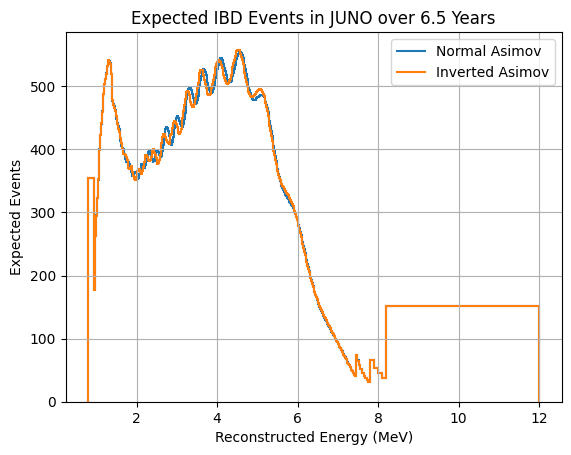

In [5]:
bin_edges = (
    [
        0.8,
    ]
    + list(np.arange(0.94, 7.43, 0.02))
    + list(np.arange(7.44, 7.79, 0.04))
    + list(np.arange(7.80, 8.21, 0.10))
    + [12.0]
)
bin_edges = np.array(bin_edges)  # MeV

plt.stairs(data_normal_asimov, bin_edges, label="Normal Asimov", linewidth=1.5)
plt.stairs(data_inverted_asimov, bin_edges, label="Inverted Asimov", linewidth=1.5)
plt.xlabel("Reconstructed Energy (MeV)")
plt.ylabel("Expected Events")
plt.title("Expected IBD Events in JUNO over 6.5 Years")
plt.legend()
plt.grid()
plt.show()

In [6]:
# We define a cost function to be used in iminuit
def cost_function_normal(
    delta_m21_squared, delta_m32_squared, s_theta_12_squared, s_theta_13_squared
):
    bin_counts = get_signal_and_bkg(
        delta_m21_squared, delta_m32_squared, s_theta_12_squared, s_theta_13_squared
    )
    # Here we would compare bin_counts to some observed data to compute chi-square or likelihood
    chi2 = np.sum(
        (data_normal_asimov - bin_counts) ** 2 / (bin_counts + 1e-10)
    )  # Adding small number to avoid division by zero

    # We also add a Gaussian prior on s_theta_13_squared
    s_theta_13_prior_mean = 0.0218
    s_theta_13_prior_sigma = 0.0007
    chi2 += ((s_theta_13_squared - s_theta_13_prior_mean) / s_theta_13_prior_sigma) ** 2

    return chi2


def cost_function_inverted(
    delta_m21_squared, delta_m32_squared, s_theta_12_squared, s_theta_13_squared
):
    bin_counts = get_signal_and_bkg(
        delta_m21_squared, delta_m32_squared, s_theta_12_squared, s_theta_13_squared
    )
    # Here we would compare bin_counts to some observed data to compute chi-square or likelihood
    chi2 = np.sum(
        (data_inverted_asimov - bin_counts) ** 2 / (bin_counts + 1e-10)
    )  # Adding small number to avoid division by zero

    # We also add a Gaussian prior on s_theta_13_squared
    s_theta_13_prior_mean = 0.0218
    s_theta_13_prior_sigma = 0.0007
    chi2 += ((s_theta_13_squared - s_theta_13_prior_mean) / s_theta_13_prior_sigma) ** 2

    return chi2

In [7]:
# Now we can use iminuit to minimize the cost_function
from iminuit import Minuit

m_normal = Minuit(
    cost_function_normal,
    delta_m32_squared=-2.546e-3,
    delta_m21_squared=7.53e-5,
    s_theta_12_squared=0.307,
    s_theta_13_squared=0.0218,
)
m_normal.limits["delta_m21_squared"] = (0, 1e-4)
m_normal.limits["delta_m32_squared"] = (-1e-2, 0)

m_normal.limits["s_theta_12_squared"] = (0, 1)
m_normal.limits["s_theta_13_squared"] = (0, 1)
m_normal.migrad()  # Perform the minimization

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 10.75                      │              Nfcn = 79               │
│ EDM = 5.58e-05 (Goal: 0.0002)    │            time = 2.8 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name               │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ delta_m21_squared  │ 75.30e-6  │  0.12e-6  │            │            │    0    │ 0.0001  │       │
│ 1 │ delta_m32_squared  │ -2.578e-3 │ 0.004e-3  │            │            │  -0.01  │    0    │       │
│ 2 │ s_theta_12_squared │ 307.0e-3  │  0.8e-3   │            │            │    0    │    1    │       │
│ 3 │ s_theta_13_squared │  21.7e-3  │  0.7e-3   │            │            │    0    │    1    │       │
└───┴────────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────────────────┬─────────────────────────────────────────────────────────────────────────────┐
│                    │  delta_m21_squared  delta_m32_squared s_theta_12_squared s_theta_13_squared │
├────────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│  delta_m21_squared │            1.4e-14         -0.015e-12        -26.212e-12         -4.976e-12 │
│  delta_m32_squared │         -0.015e-12           1.63e-11           0.058e-9          -0.010e-9 │
│ s_theta_12_squared │        -26.212e-12           0.058e-9           6.43e-07            -0.2e-6 │
│ s_theta_13_squared │         -4.976e-12          -0.010e-9            -0.2e-6           4.25e-07 │
└────────────────────┴─────────────────────────────────────────────────────────────────────────────┘

In [8]:
m_inverted = Minuit(
    cost_function_inverted,
    delta_m32_squared=2.453e-3,
    delta_m21_squared=7.53e-5,
    s_theta_12_squared=0.307,
    s_theta_13_squared=0.0218,
)
m_inverted.limits["delta_m21_squared"] = (0, 1e-4)
m_inverted.limits["delta_m32_squared"] = (0, 1e-2)

m_inverted.limits["s_theta_12_squared"] = (0, 1)
m_inverted.limits["s_theta_13_squared"] = (0, 1)
m_inverted.migrad()  # Perform the minimization

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 11.37                      │              Nfcn = 79               │
│ EDM = 4.92e-05 (Goal: 0.0002)    │            time = 2.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name               │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ delta_m21_squared  │ 75.30e-6  │  0.12e-6  │            │            │    0    │ 0.0001  │       │
│ 1 │ delta_m32_squared  │ 2.421e-3  │ 0.004e-3  │            │            │    0    │  0.01   │       │
│ 2 │ s_theta_12_squared │ 307.0e-3  │  0.8e-3   │            │            │    0    │    1    │       │
│ 3 │ s_theta_13_squared │  21.7e-3  │  0.7e-3   │            │            │    0    │    1    │       │
└───┴────────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────────────────┬─────────────────────────────────────────────────────────────────────────────┐
│                    │  delta_m21_squared  delta_m32_squared s_theta_12_squared s_theta_13_squared │
├────────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│  delta_m21_squared │            1.4e-14         -0.015e-12        -26.227e-12         -4.968e-12 │
│  delta_m32_squared │         -0.015e-12            1.6e-11           0.059e-9           0.011e-9 │
│ s_theta_12_squared │        -26.227e-12           0.059e-9           6.43e-07            -0.1e-6 │
│ s_theta_13_squared │         -4.968e-12           0.011e-9            -0.1e-6           4.26e-07 │
└────────────────────┴─────────────────────────────────────────────────────────────────────────────┘

In [9]:
print("Minimum chi-square (normal):", m_normal.fval)  # Expected 11.5
print("Best-fit parameters (normal):", m_normal.values)
print("Minimum chi-square (inverted):", m_inverted.fval)
print("Best-fit parameters (inverted):", m_inverted.values)

Minimum chi-square (normal): 10.750390941919862
Best-fit parameters (normal): <ValueView delta_m21_squared=7.529867835577425e-05 delta_m32_squared=-0.0025779897628406064 s_theta_12_squared=0.3070141924089887 s_theta_13_squared=0.021663410711530245>
Minimum chi-square (inverted): 11.368236616473595
Best-fit parameters (inverted): <ValueView delta_m21_squared=7.5298462518067e-05 delta_m32_squared=0.00242095582231762 s_theta_12_squared=0.3070104837357938 s_theta_13_squared=0.021731269599666536>


Now we streamline the entire process to be handled in a single class JUNOSensitivity.

It is interesting to see the effect of the MSW effect. We disable the MSW effect by setting $\rho = 0$

In [10]:
from sensitivity import JUNOSensitivity

juno_sensitivity = JUNOSensitivity(sv, detector)
cost_function_no_vacuum = juno_sensitivity.build_cost_function(
    hierarchy="normal", ns_kwargs={"rho": 1e-10}
)
cost_function_io_vacuum = juno_sensitivity.build_cost_function(
    hierarchy="inverted", ns_kwargs={"rho": 1e-10}
)

m_no_vacuum = Minuit(
    cost_function_no_vacuum,
    delta_m32_squared=-2.546e-3,
    delta_m21_squared=7.53e-5,
    s_theta_12_squared=0.307,
    s_theta_13_squared=0.0218,
)

m_no_vacuum.strategy = 2
m_no_vacuum.errordef = Minuit.LEAST_SQUARES
m_no_vacuum.tol = 1e-10

m_no_vacuum.limits["delta_m21_squared"] = (0, 1e-4)
m_no_vacuum.limits["delta_m32_squared"] = (-1e-2, 0)
m_no_vacuum.limits["s_theta_12_squared"] = (0, 1)
m_no_vacuum.limits["s_theta_13_squared"] = (0, 1)
m_no_vacuum.migrad()  # Perform the minimization
m_no_vacuum.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 11.33                      │              Nfcn = 306              │
│ EDM = 1.63e-12 (Goal: 1.19e-10)  │            time = 0.8 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name               │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ delta_m21_squared  │ 75.30e-6  │  0.12e-6  │  -0.12e-6  │  0.12e-6   │    0    │ 0.0001  │       │
│ 1 │ delta_m32_squared  │ -2.576e-3 │ 0.004e-3  │ -0.004e-3  │  0.004e-3  │  -0.01  │    0    │       │
│ 2 │ s_theta_12_squared │ 307.0e-3  │  0.8e-3   │  -0.8e-3   │   0.8e-3   │    0    │    1    │       │
│ 3 │ s_theta_13_squared │  21.7e-3  │  0.7e-3   │  -0.7e-3   │   0.7e-3   │    0    │    1    │       │
└───┴────────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │   delta_m21_squared   │   delta_m32_squared   │  s_theta_12_squared   │  s_theta_13_squared   │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │ -0.12e-6  │  0.12e-6  │   -4e-6   │   4e-6    │  -0.8e-3  │  0.8e-3   │  -0.7e-3  │  0.7e-3   │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌────────────────────┬─────────────────────────────────────────────────────────────────────────────┐
│                    │  delta_m21_squared  delta_m32_squared s_theta_12_squared s_theta_13_squared │
├────────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│  delta_m21_squared │           1.38e-14         -0.015e-12        -26.736e-12         -4.989e-12 │
│  delta_m32_squared │         -0.015e-12           1.64e-11           0.058e-9          -0.011e-9 │
│ s_theta_12_squared │        -26.736e-12           0.058e-9           6.45e-07            -0.1e-6 │
│ s_theta_13_squared │         -4.989e-12          -0.011e-9            -0.1e-6           4.25e-07 │
└────────────────────┴─────────────────────────────────────────────────────────────────────────────┘

In [11]:
m_io_vacuum = Minuit(
    cost_function_io_vacuum,
    delta_m32_squared=2.453e-3,
    delta_m21_squared=7.53e-5,
    s_theta_12_squared=0.307,
    s_theta_13_squared=0.0218,
)
m_io_vacuum.limits["delta_m21_squared"] = (0, 1e-4)
m_io_vacuum.limits["delta_m32_squared"] = (0, 1e-2)
m_io_vacuum.limits["s_theta_12_squared"] = (0, 1)
m_io_vacuum.limits["s_theta_13_squared"] = (0, 1)
m_io_vacuum.migrad()  # Perform the minimization

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 11.94                      │              Nfcn = 79               │
│ EDM = 5e-05 (Goal: 0.0002)       │            time = 2.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name               │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ delta_m21_squared  │ 75.30e-6  │  0.12e-6  │            │            │    0    │ 0.0001  │       │
│ 1 │ delta_m32_squared  │ 2.423e-3  │ 0.004e-3  │            │            │    0    │  0.01   │       │
│ 2 │ s_theta_12_squared │ 307.0e-3  │  0.8e-3   │            │            │    0    │    1    │       │
│ 3 │ s_theta_13_squared │  21.7e-3  │  0.7e-3   │            │            │    0    │    1    │       │
└───┴────────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────────────────┬─────────────────────────────────────────────────────────────────────────────┐
│                    │  delta_m21_squared  delta_m32_squared s_theta_12_squared s_theta_13_squared │
├────────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│  delta_m21_squared │           1.38e-14         -0.015e-12        -26.741e-12         -4.998e-12 │
│  delta_m32_squared │         -0.015e-12           1.62e-11           0.060e-9           0.011e-9 │
│ s_theta_12_squared │        -26.741e-12           0.060e-9           6.45e-07            -0.1e-6 │
│ s_theta_13_squared │         -4.998e-12           0.011e-9            -0.1e-6           4.26e-07 │
└────────────────────┴─────────────────────────────────────────────────────────────────────────────┘

In [12]:
print("Minimum chi-square no MSW (normal):", m_no_vacuum.fval)
print("Best-fit parameters no MSW (normal):", m_no_vacuum.values)
print("Minimum chi-square no MSW (inverted):", m_io_vacuum.fval)
print("Best-fit parameters no MSW (inverted):", m_io_vacuum.values)

Minimum chi-square no MSW (normal): 11.33138829223136
Best-fit parameters no MSW (normal): <ValueView delta_m21_squared=7.530035846270246e-05 delta_m32_squared=-0.002575917105467937 s_theta_12_squared=0.30701768844168703 s_theta_13_squared=0.021660275603055893>
Minimum chi-square no MSW (inverted): 11.93522221350676
Best-fit parameters no MSW (inverted): <ValueView delta_m21_squared=7.529773560806529e-05 delta_m32_squared=0.0024230479366370307 s_theta_12_squared=0.30700449594561074 s_theta_13_squared=0.0217223057303939>


Also interesting to compare the two-neutrino approximation and the DMP approach. They should agree perfectly for the vacuum case.

In [13]:
juno_sensitivity_approx = JUNOSensitivity(sv, detector, use_dmp=False)
cost_function_no_approx_vacuum = juno_sensitivity_approx.build_cost_function(
    hierarchy="normal", ns_kwargs={"rho": 1e-10}
)
cost_function_io_approx_vacuum = juno_sensitivity_approx.build_cost_function(
    hierarchy="inverted", ns_kwargs={"rho": 1e-10}
)
m_no_approx_vacuum = Minuit(
    cost_function_no_approx_vacuum,
    delta_m32_squared=-2.546e-3,
    delta_m21_squared=7.53e-5,
    s_theta_12_squared=0.307,
    s_theta_13_squared=0.0218,
)
m_no_approx_vacuum.strategy = 2
m_no_approx_vacuum.errordef = Minuit.LEAST_SQUARES
m_no_approx_vacuum.tol = 1e-10
m_no_approx_vacuum.limits["delta_m21_squared"] = (0, 1e-4)
m_no_approx_vacuum.limits["delta_m32_squared"] = (-1e-2, 0)
m_no_approx_vacuum.limits["s_theta_12_squared"] = (0, 1)
m_no_approx_vacuum.limits["s_theta_13_squared"] = (0, 1)
m_no_approx_vacuum.migrad()  # Perform the minimization

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 11.33                      │              Nfcn = 124              │
│ EDM = 2.08e-15 (Goal: 1.19e-10)  │            time = 2.8 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name               │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ delta_m21_squared  │ 75.30e-6  │  0.12e-6  │            │            │    0    │ 0.0001  │       │
│ 1 │ delta_m32_squared  │ -2.576e-3 │ 0.004e-3  │            │            │  -0.01  │    0    │       │
│ 2 │ s_theta_12_squared │ 307.0e-3  │  0.8e-3   │            │            │    0    │    1    │       │
│ 3 │ s_theta_13_squared │  21.7e-3  │  0.7e-3   │            │            │    0    │    1    │       │
└───┴────────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────────────────┬─────────────────────────────────────────────────────────────────────────────┐
│                    │  delta_m21_squared  delta_m32_squared s_theta_12_squared s_theta_13_squared │
├────────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│  delta_m21_squared │           1.38e-14         -0.015e-12        -26.736e-12         -4.989e-12 │
│  delta_m32_squared │         -0.015e-12           1.64e-11           0.058e-9          -0.011e-9 │
│ s_theta_12_squared │        -26.736e-12           0.058e-9           6.45e-07            -0.1e-6 │
│ s_theta_13_squared │         -4.989e-12          -0.011e-9            -0.1e-6           4.25e-07 │
└────────────────────┴─────────────────────────────────────────────────────────────────────────────┘

In [14]:
juno_sensitivity_approx = JUNOSensitivity(sv, detector, use_dmp=False)
cost_function_no_approx = juno_sensitivity_approx.build_cost_function(
    hierarchy="normal", ns_kwargs=None
)
cost_function_io_approx = juno_sensitivity_approx.build_cost_function(
    hierarchy="inverted", ns_kwargs=None
)
m_no_approx = Minuit(
    cost_function_no_approx,
    delta_m32_squared=-2.546e-3,
    delta_m21_squared=7.53e-5,
    s_theta_12_squared=0.307,
    s_theta_13_squared=0.0218,
)
m_no_approx.limits["delta_m21_squared"] = (0, 1e-4)
m_no_approx.limits["delta_m32_squared"] = (-1e-2, 0)
m_no_approx.limits["s_theta_12_squared"] = (0, 1)
m_no_approx.limits["s_theta_13_squared"] = (0, 1)
m_no_approx.migrad()  # Perform the minimization

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 10.59                      │              Nfcn = 79               │
│ EDM = 5.71e-05 (Goal: 0.0002)    │            time = 1.8 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name               │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ delta_m21_squared  │ 75.30e-6  │  0.12e-6  │            │            │    0    │ 0.0001  │       │
│ 1 │ delta_m32_squared  │ -2.579e-3 │ 0.004e-3  │            │            │  -0.01  │    0    │       │
│ 2 │ s_theta_12_squared │ 307.0e-3  │  0.8e-3   │            │            │    0    │    1    │       │
│ 3 │ s_theta_13_squared │  21.7e-3  │  0.7e-3   │            │            │    0    │    1    │       │
└───┴────────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────────────────┬─────────────────────────────────────────────────────────────────────────────┐
│                    │  delta_m21_squared  delta_m32_squared s_theta_12_squared s_theta_13_squared │
├────────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│  delta_m21_squared │            1.4e-14         -0.015e-12        -26.212e-12         -4.976e-12 │
│  delta_m32_squared │         -0.015e-12           1.63e-11           0.057e-9          -0.010e-9 │
│ s_theta_12_squared │        -26.212e-12           0.057e-9           6.43e-07            -0.2e-6 │
│ s_theta_13_squared │         -4.976e-12          -0.010e-9            -0.2e-6           4.25e-07 │
└────────────────────┴─────────────────────────────────────────────────────────────────────────────┘

Let's compute for another energy resolution.

Response matrix loaded from juno_detector_response_matrix_77880634.npz


100%|██████████| 20/20 [01:44<00:00,  5.24s/it]


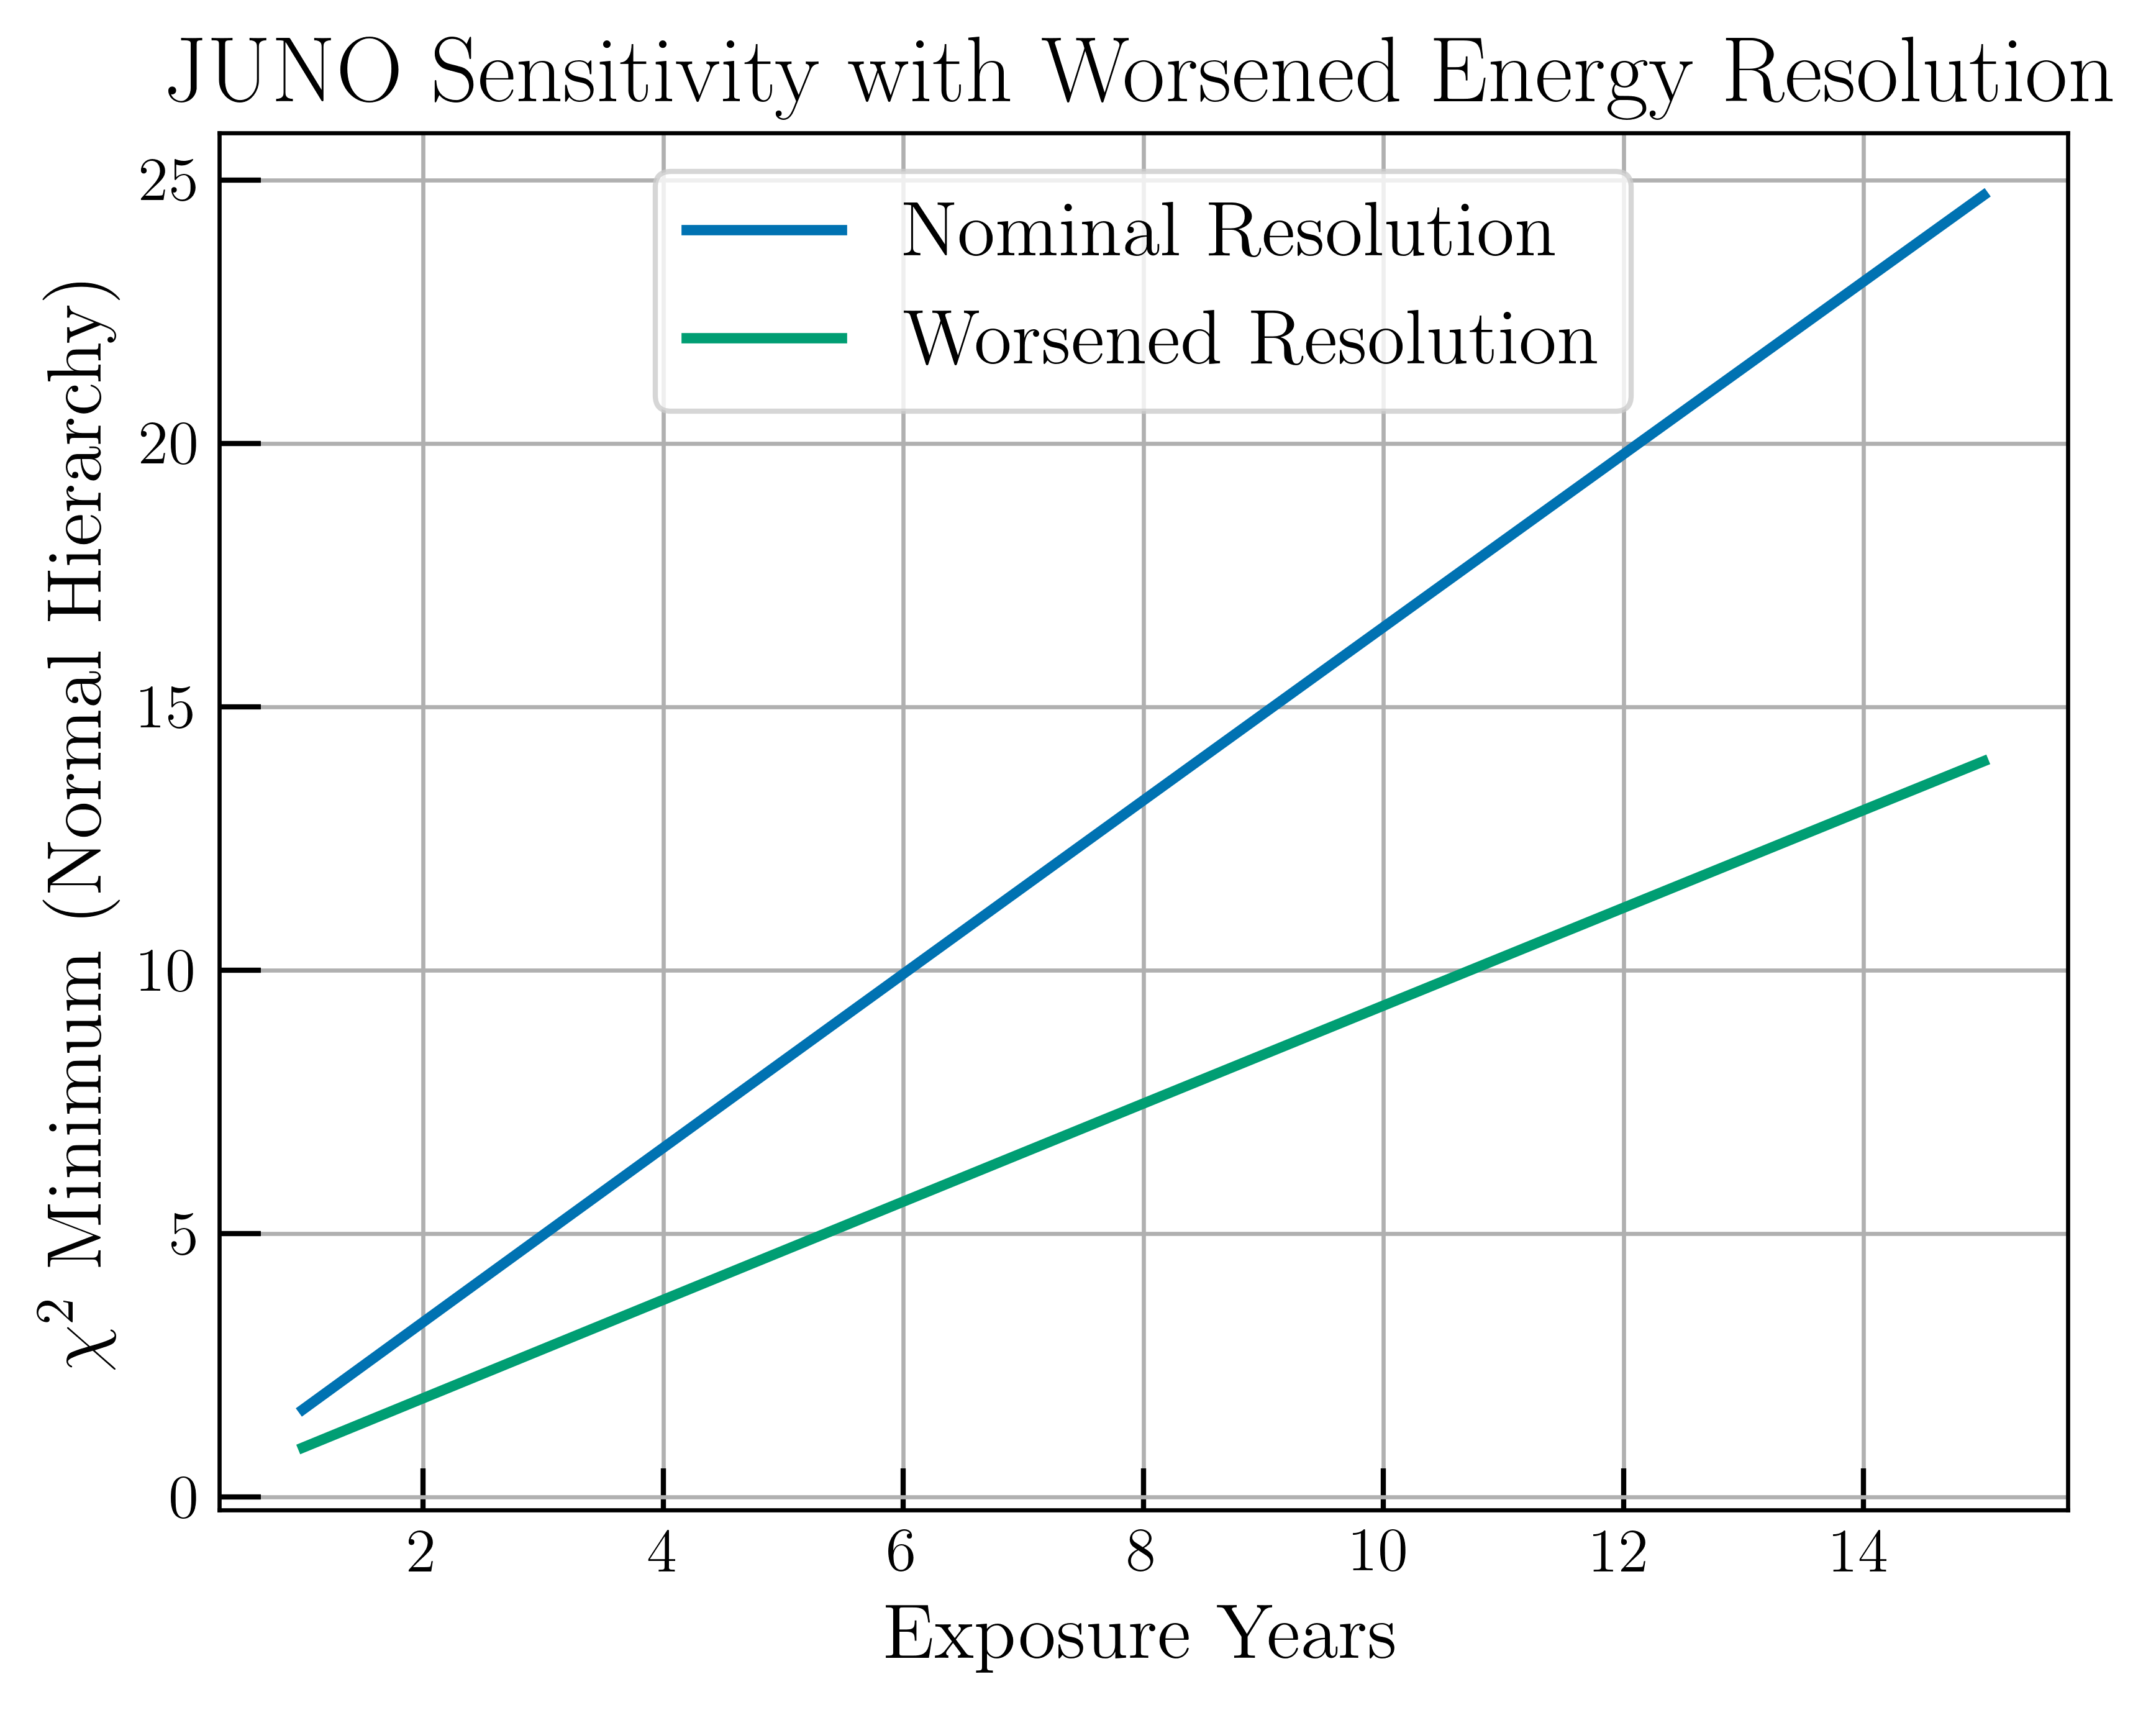

In [ ]:
from tqdm import tqdm

detector_worsened = JUNODetector(sv, a=0.033, b=0, c=0.01)
try:
    detector_worsened.load_response_matrix()
except FileNotFoundError:
    detector_worsened.build_response_matrix(E_nu_grid_detector, E_rec_grid)
    detector_worsened.save_response_matrix()

juno_sensitivity_worsened = JUNOSensitivity(sv, detector_worsened)
exposure_years_scan = np.linspace(1, 15, 20)
chi_square_no_scan_worsened = np.zeros_like(exposure_years_scan)
chi_square_no_scan = np.zeros_like(exposure_years_scan)
for i, exposure_years in enumerate(tqdm(exposure_years_scan)):
    cost_function_no = juno_sensitivity.build_cost_function(
        hierarchy="normal", ns_kwargs=None, exposure_years=exposure_years
    )
    cost_function_no_worsened = juno_sensitivity_worsened.build_cost_function(
        hierarchy="normal", ns_kwargs=None, exposure_years=exposure_years
    )
    m_no = Minuit(
        cost_function_no,
        delta_m32_squared=-2.546e-3,
        delta_m21_squared=7.53e-5,
        s_theta_12_squared=0.307,
        s_theta_13_squared=0.0218,
    )
    m_no.limits["delta_m21_squared"] = (0, 1e-4)
    m_no.limits["delta_m32_squared"] = (-1e-2, 0)
    m_no.limits["s_theta_12_squared"] = (0, 1)
    m_no.limits["s_theta_13_squared"] = (0, 1)
    m_no.migrad()  # Perform the minimization
    m_no_worsened = Minuit(
        cost_function_no_worsened,
        delta_m32_squared=-2.546e-3,
        delta_m21_squared=7.53e-5,
        s_theta_12_squared=0.307,
        s_theta_13_squared=0.0218,
    )
    m_no_worsened.limits["delta_m21_squared"] = (0, 1e-4)
    m_no_worsened.limits["delta_m32_squared"] = (-1e-2, 0)
    m_no_worsened.limits["s_theta_12_squared"] = (0, 1)
    m_no_worsened.limits["s_theta_13_squared"] = (0, 1)
    m_no_worsened.migrad()  # Perform the minimization

    chi_square_no_scan[i] = m_no.fval
    chi_square_no_scan_worsened[i] = m_no_worsened.fval

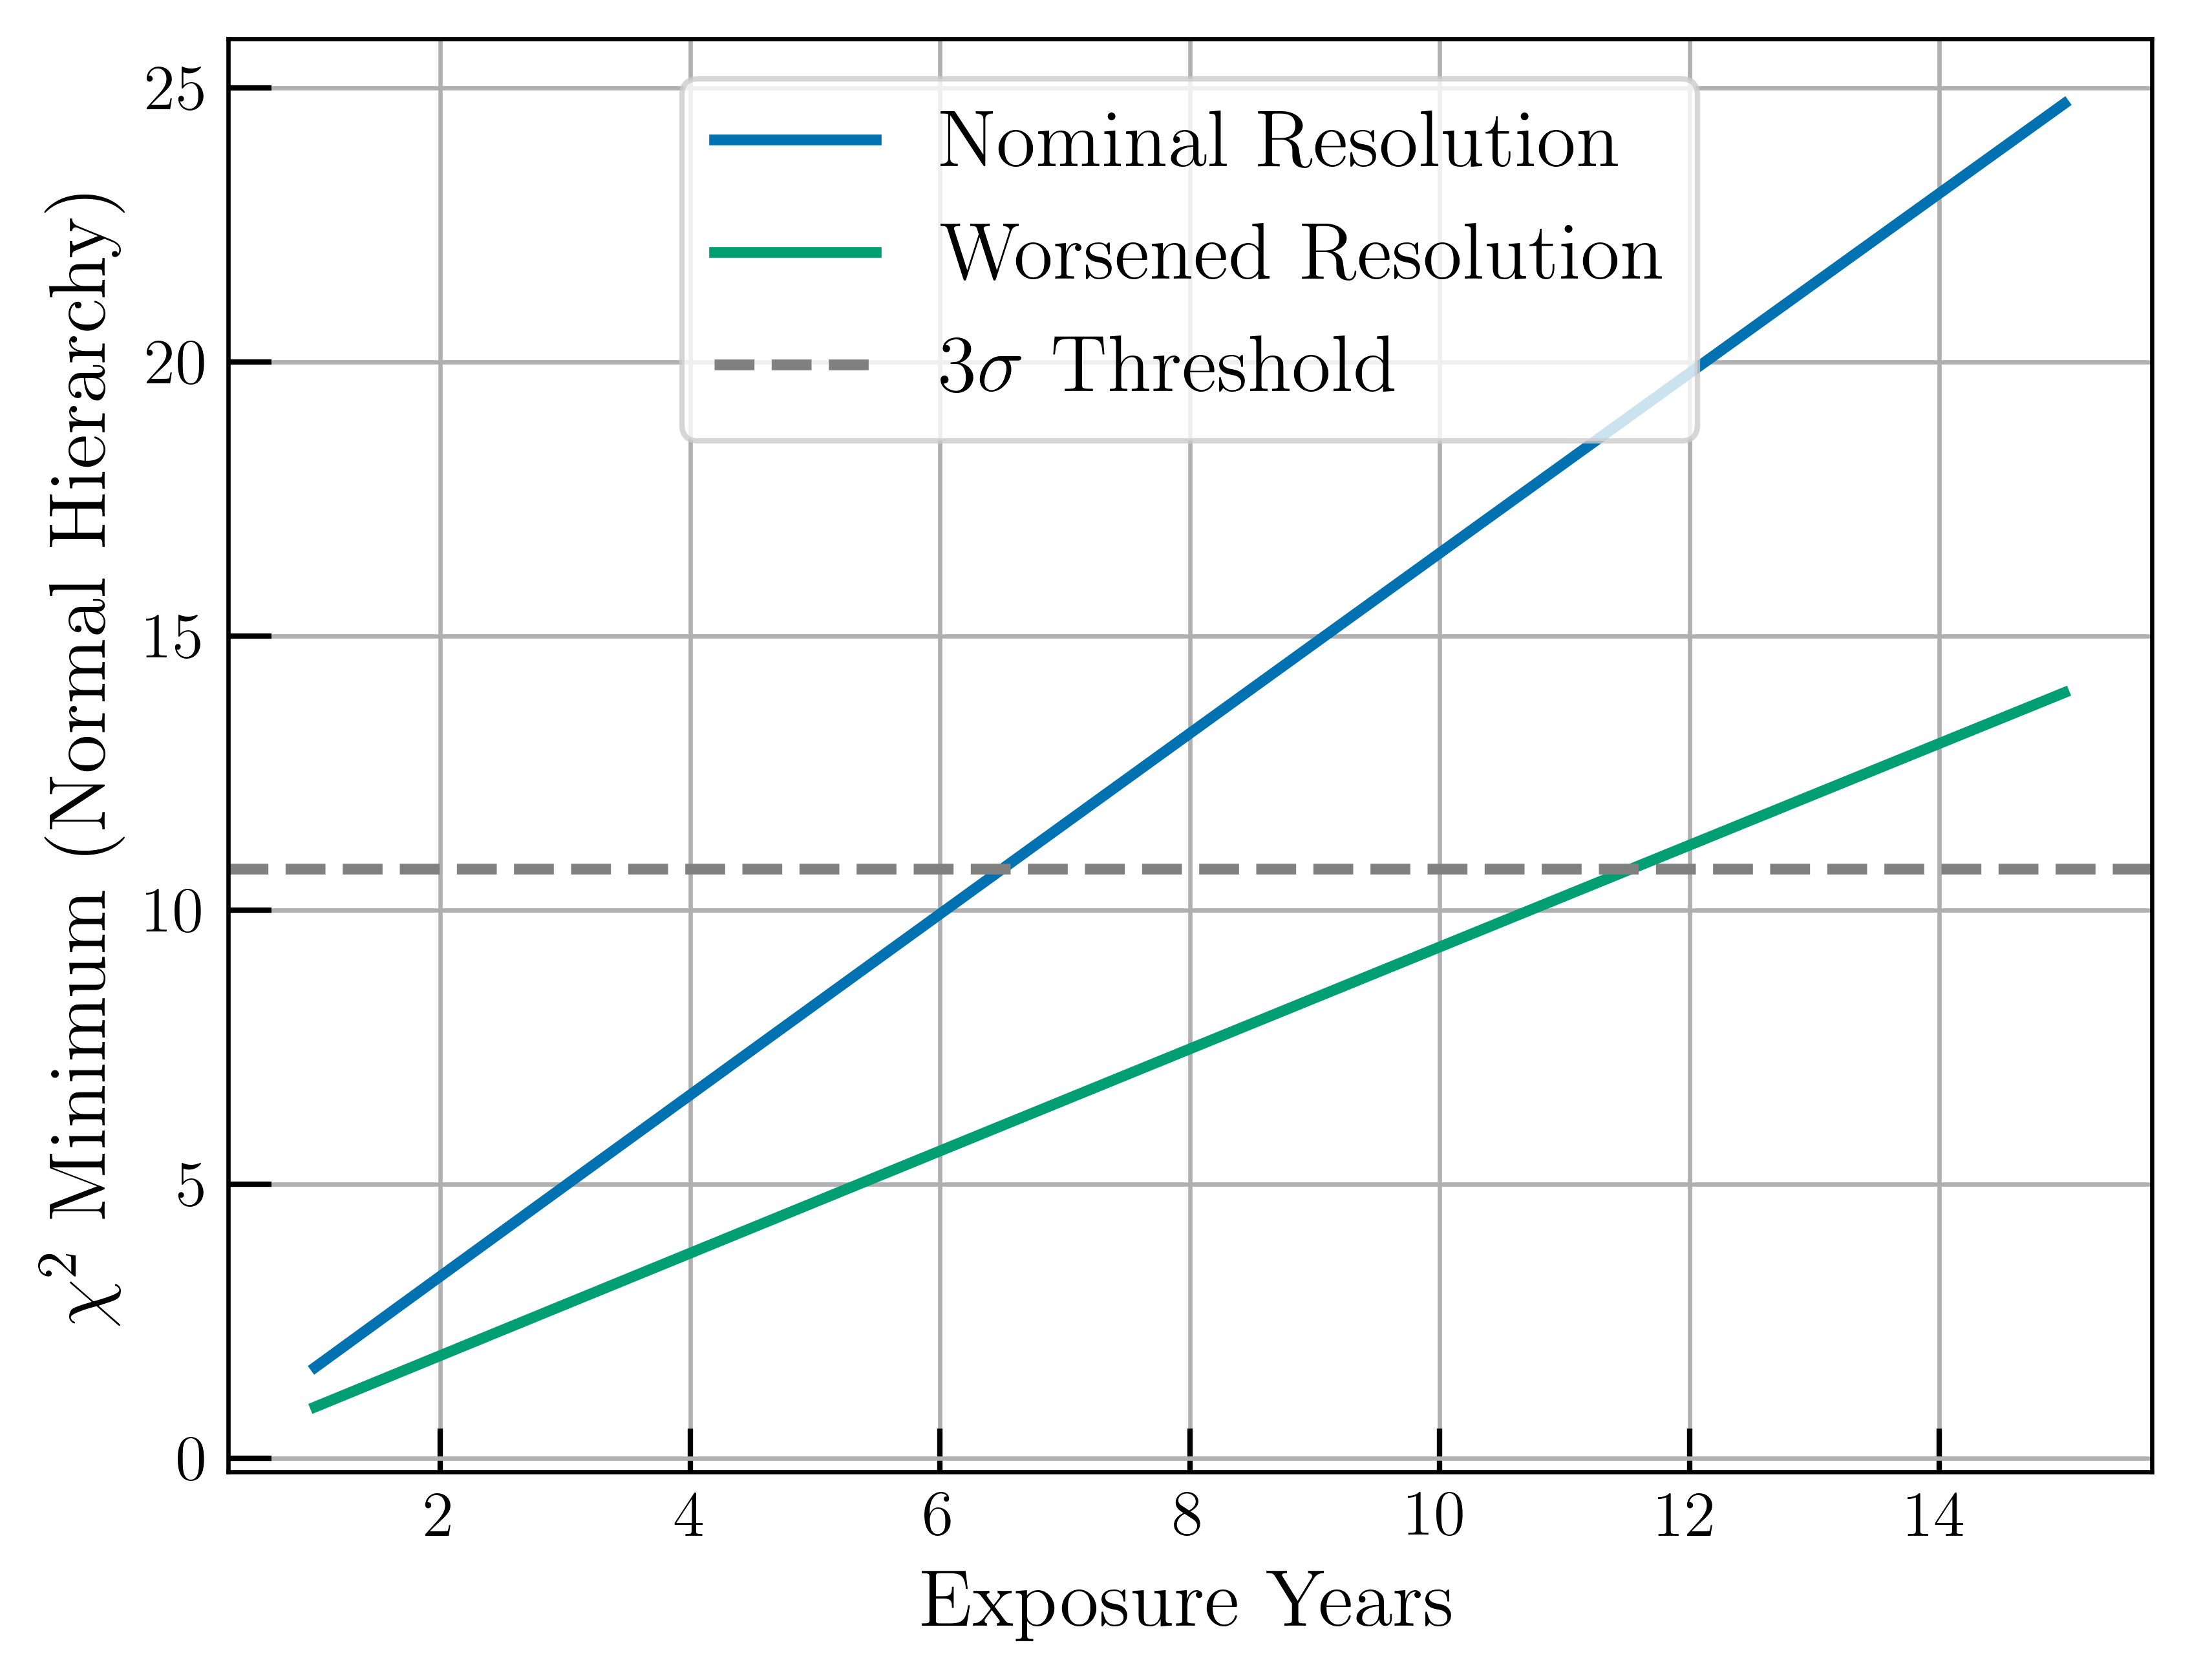

In [20]:
plt.plot(exposure_years_scan, chi_square_no_scan, label="Nominal Resolution")
plt.plot(exposure_years_scan, chi_square_no_scan_worsened, label="Worsened Resolution")
plt.axhline(10.75, color="gray", linestyle="--", label=r"$3\sigma$ Threshold")
plt.xlabel("Exposure Years")
plt.ylabel(r"$\chi^2$ Minimum (Normal Hierarchy)")
# plt.title("JUNO Sensitivity with Worsened Energy Resolution")
plt.legend()
plt.grid()
plt.savefig(
    "./plots/juno_sensitivity_worsened_energy_resolution.pdf", bbox_inches="tight"
)

In [23]:
# Find the slope of the chi-square curve with respect to exposure years
# As the relationship is approximately linear, we can use a simple linear fit
slope, intercept = np.polyfit(exposure_years_scan, chi_square_no_scan, 1)
slope_worsened, intercept_worsened = np.polyfit(
    exposure_years_scan, chi_square_no_scan_worsened, 1
)
print(f"Slope of chi-square vs exposure years: {slope} per year")
print(f"Slope of chi-square vs exposure years (worsened): {slope_worsened} per year")
print("Ratio of slopes (nominal/worsened):", slope / slope_worsened)

Slope of chi-square vs exposure years: 1.6461341715170563 per year
Slope of chi-square vs exposure years (worsened): 0.9304534814340264 per year
Ratio of slopes (nominal/worsened): 1.7691740687347572
